In [9]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from numpy.random import normal, choice, rand, beta, binomial, randint, dirichlet
from numpy.linalg import matrix_rank, norm, svd, eig, qr
from scipy.linalg import pinv
from scipy import interpolate
from scipy.stats import entropy
import time

import warnings
warnings.filterwarnings('ignore')

In [10]:
ncfile = Dataset("data/uwnd.202010.nc")
uwnd = np.squeeze(ncfile.variables['uwnd'])
ncfile.close()
uwnd = uwnd[:,16,:252,1:337]

In [11]:
ncfile = Dataset("data/vwnd.202010.nc")
vwnd = np.squeeze(ncfile.variables['vwnd'])
ncfile.close()
vwnd = vwnd[:,16,:252,1:337]

In [12]:
wf = np.zeros((248,252,336,2))
wf[:,:,:,0] = uwnd
wf[:,:,:,1] = vwnd

In [13]:
A = wf
del wf, uwnd, vwnd
N = A.shape

In [14]:
N

(248, 252, 336, 2)

In [15]:
# matrix unfoldings
def unfoldings(A):
    N = A.shape
    output = [A.reshape(N[0],np.int(A.size/N[0]))]
    for i in range(1,len(N)):
        A = np.moveaxis(A,0,-1)
        output.append(A.reshape(N[i],np.int(A.size/N[i])))
    return output

In [16]:
[A0, A1, A2, A3] = unfoldings(A)

In [17]:
def HOSVD_rank(A):
    [A0, A1, A2, A3] = unfoldings(A)
    _, s0, _ = svd(A0,full_matrices=False)
    _, s1, _ = svd(A1,full_matrices=False)
    _, s2, _ = svd(A2,full_matrices=False)
    _, s3, _ = svd(A3,full_matrices=False)
    
    scree0 = []
    scree1 = []
    scree2 = []
    scree3 = []
    for r in range(s0.shape[0]):
        scree0.append(norm(s0[r+1:])**2 / norm(A0)**2)
        if norm(s0[r+1:])**2 / norm(A0)**2 < 1e-7 :
                break
    for r in range(s1.shape[0]):
        scree1.append(norm(s1[r+1:])**2 / norm(A1)**2)
        if norm(s1[r+1:])**2 / norm(A1)**2 < 1e-7 :
                break
    for r in range(s2.shape[0]):
        scree2.append(norm(s2[r+1:])**2 / norm(A2)**2)
        if norm(s2[r+1:])**2 / norm(A2)**2 < 1e-7 :
                break
    for r in range(s3.shape[0]):
        scree3.append(norm(s3[r+1:])**2 / norm(A3)**2)   
        if norm(s3[r+1:])**2 / norm(A3)**2 < 1e-7 :
                break
                
    return [scree0, scree1, scree2, scree3]

In [18]:
scree = HOSVD_rank(A)

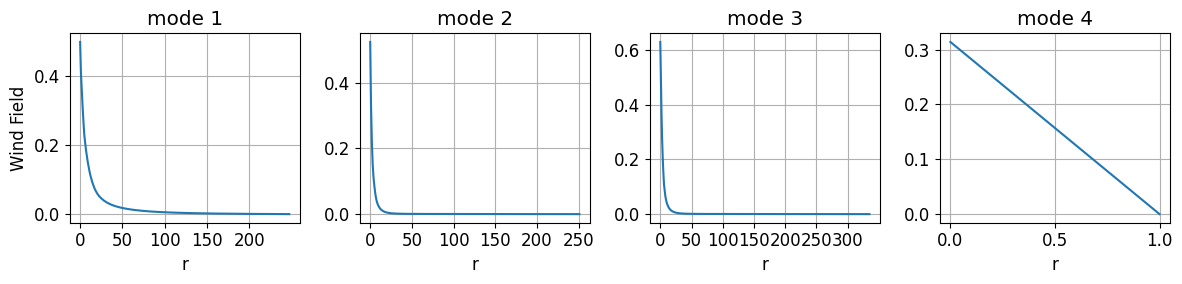

In [19]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].set_xticks(np.arange(0, N[0], 50))
ax[0].set_ylabel('Wind Field')
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].set_xticks(np.arange(0, N[1], 50))
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
ax[2].set_xticks(np.arange(0, N[2], 50))
ax[2].grid()

ax[3].plot(scree[3])
ax[3].set_title('mode 4')
ax[3].set_xlabel('r')
#ax[3].set_xticks(np.arange(0, N[2], 20))
ax[3].grid()
plt.tight_layout()
plt.savefig('plots/windfield_screes.png',dpi=300)
plt.show()

In [20]:
r = np.array([150,40,40,2])

In [45]:
def HOSVD4(A):
    [A0, A1, A2, A3] = unfoldings(A)
    U0, s0, _ = svd(A0,full_matrices=False)
    U1, s1, _ = svd(A1,full_matrices=False)
    U2, s2, _ = svd(A2,full_matrices=False)
    U3, s3, _ = svd(A3,full_matrices=False)
    
    S = np.tensordot(np.tensordot(np.tensordot(np.tensordot(A,U0.T,axes=(0,1)),
                                               U1.T,axes=(0,1)),
                                  U2.T,axes=(0,1)),
                     U3.T,axes=(0,1))
    return S, U0, U1, U2, U3

def HOSVD(A):
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    S = np.tensordot(np.tensordot(np.tensordot(A,U1.T,axes=(0,1)),
                              U2.T,axes=(0,1)),
                 U3.T,axes=(0,1))
    return S, U1, U2, U3

def linear(index,score,N):
    f = interpolate.interp1d(index, score)
    z = f(np.arange(N))
    z[index] = 0
    if np.sum(z) > 0:
        return z / np.sum(z)
    if np.sum(z) == 0:
        return None

In [46]:
def pgSketchyCoreTucker(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    [A0, A1, A2] = unfoldings(A)
    
    # computation time log
    start_time = time.time()
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    # order 2 SAD
    score_0 = np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=1)),axis=1)/N[1],axis=1) + np.sum(np.sum(np.abs(np.diff(A[index_0,:,:],axis=2)),axis=2)/N[2],axis=1)
    score_1 = np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=2)),axis=2)/N[2],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,index_1,:],axis=0)),axis=0)/N[0],axis=1)
    score_2 = np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=0)),axis=0)/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,index_2],axis=1)),axis=1)/N[1],axis=0)
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            new_score = np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=1)),axis=1)/N[1],axis=1) + np.sum(np.sum(np.abs(np.diff(A[new_index,:,:],axis=2)),axis=2)/N[2],axis=1)
            index_0 = np.append(index_0,new_index)
            score_0 = np.append(score_0,new_score)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=2)),axis=2)/N[2],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,new_index,:],axis=0)),axis=0)/N[0],axis=1)
            index_1 = np.append(index_1,new_index)
            score_1 = np.append(score_1,new_score)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            new_score = np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=0)),axis=0)/N[0],axis=0) + np.sum(np.sum(np.abs(np.diff(A[:,:,new_index],axis=1)),axis=1)/N[1],axis=0)
            index_2 = np.append(index_2,new_index)
            score_2 = np.append(score_2,new_score)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            

    # Final SketchyCoreTucker
    y0, x0 = np.meshgrid(index_1,index_2)
    y1, x1 = np.meshgrid(index_2,index_0)
    y2, x2 = np.meshgrid(index_0,index_1)
    fibers_0 = (x0 + y0*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0]).reshape(-1)
    fibers_2 = (x2 + y2*N[1]).reshape(-1)
    
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time  
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
    
    return Ar, err, m, time_TS

In [47]:
def Random_SketchyCoreTucker(A,r,M):
    N = np.array(A.shape)
    m = N+1
    while (m[0] > N[0]) or (m[1] > N[1]) or (m[2] > N[2]):
        m = np.array(dirichlet([1,1,1],1)[0] * M,dtype=np.int)
    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)
       
    # matrix unfoldings
    [A0, A1, A2] = unfoldings(A)
    
    # computation time log
    start_time = time.time()
    
    # inital core uniform sampling
    index_0 = choice(N[0], size=m[0], replace=False)
    index_1 = choice(N[1], size=m[1], replace=False) 
    index_2 = choice(N[2], size=m[2], replace=False)
    
    fibers_0 = choice(N[1]*N[2],m[1]*m[2],replace=False)
    fibers_1 = choice(N[2]*N[0],m[2]*m[0],replace=False)
    fibers_2 = choice(N[0]*N[1],m[0]*m[1],replace=False)
    
    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    
    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    
    delta0, delta1, delta2 = np.meshgrid(index_0, index_1, index_2, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2],Map0,axes=(0,1)),
                                  Map1,axes=(0,1)),
                     Map2,axes=(0,1))
    
    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    
    C = np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                  pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                     pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1))
    
    S, U1, U2, U3 = HOSVD(C)
    
    Cr = np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U1[:,:r[0]],axes=(0,1)),
                                   U2[:,:r[1]],axes=(0,1)),
                      U3[:,:r[2]],axes=(0,1))
    
    time_TS = time.time() - start_time 
    
    Ar = np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                   Q1,axes=(0,1)),
                      Q2,axes=(0,1))
    
    err = norm(A - Ar)**2 / norm(A)**2
        
    return Ar, err, time_TS

In [48]:
def pgskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    #[A0, A1, A2, A3] = unfoldings(A)
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
    # order 2 SAD
    score_0 = np.sum(np.sum(np.sum(np.abs(np.diff(A[index_0,:,:,:],axis=1)),axis=1),axis=1),axis=1)/N[1]/N[2]/N[3] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[index_0,:,:,:],axis=2)),axis=2),axis=1),axis=1)/N[1]/N[2]/N[3] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[index_0,:,:,:],axis=3)),axis=3),axis=1),axis=1)/N[1]/N[2]/N[3]
    score_1 = np.sum(np.sum(np.sum(np.abs(np.diff(A[:,index_1,:,:],axis=0)),axis=0),axis=1),axis=1)/N[2]/N[3]/N[0] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[:,index_1,:,:],axis=2)),axis=2),axis=0),axis=1)/N[2]/N[3]/N[0] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[:,index_1,:,:],axis=3)),axis=3),axis=0),axis=1)/N[2]/N[3]/N[0] 
    score_2 = np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,index_2,:],axis=0)),axis=0),axis=0),axis=1)/N[0]/N[1]/N[2] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,index_2,:],axis=1)),axis=1),axis=0),axis=1)/N[0]/N[1]/N[2] + \
              np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,index_2,:],axis=3)),axis=3),axis=0),axis=0)/N[0]/N[1]/N[2]
    
    # bilinear interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    z_2 = linear(index_2,score_2,N[2])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            new_index = choice(N[0],add,replace=False,p=z_0)
            new_score = np.sum(np.sum(np.sum(np.abs(np.diff(A[new_index,:,:,:],axis=1)),axis=1),axis=1),axis=1)/N[1]/N[2]/N[3] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[new_index,:,:,:],axis=2)),axis=2),axis=1),axis=1)/N[1]/N[2]/N[3] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[new_index,:,:,:],axis=3)),axis=3),axis=1),axis=1)/N[1]/N[2]/N[3]
            index_0 = np.append(index_0,new_index)
            score_0 = np.append(score_0,new_score)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            new_index = choice(N[1],add,replace=False,p=z_1)
            new_score = np.sum(np.sum(np.sum(np.abs(np.diff(A[:,new_index,:,:],axis=0)),axis=0),axis=1),axis=1)/N[2]/N[3]/N[0] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[:,new_index,:,:],axis=2)),axis=2),axis=0),axis=1)/N[2]/N[3]/N[0] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[:,new_index,:,:],axis=3)),axis=3),axis=0),axis=1)/N[2]/N[3]/N[0]
            index_1 = np.append(index_1,new_index)
            score_1 = np.append(score_1,new_score)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
        
        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            new_index = choice(N[2],add,replace=False,p=z_2)
            new_score = np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,new_index,:],axis=0)),axis=0),axis=0),axis=1)/N[0]/N[1]/N[2] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,new_index,:],axis=1)),axis=1),axis=0),axis=1)/N[0]/N[1]/N[2] + \
                        np.sum(np.sum(np.sum(np.abs(np.diff(A[:,:,new_index,:],axis=3)),axis=3),axis=0),axis=0)/N[0]/N[1]/N[2]
            index_2 = np.append(index_2,new_index)
            score_2 = np.append(score_2,new_score)
            z_2 = linear(index_2, score_2, N[2])
            params[2] = entropy(score_2)
            
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [49]:
def rdskt_log(A,r,start,step,stop):
    N = np.array(A.shape)
    m = np.array([start,start,start],dtype=np.int)
    params = [1,1,1]
    
    # matrix unfoldings
    #[A0, A1, A2, A3] = unfoldings(A)
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,[0,N[0]-1])
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,[0,N[1]-1])
    index_2 = np.append(choice(N[2]-2,start-2,replace=False)+1,[0,N[2]-1])
    
    index_0_log = [index_0.tolist()]
    index_1_log = [index_1.tolist()]
    index_2_log = [index_2.tolist()]
    
        
    # bilinear interpolation
    z_0 = np.arange(N[0])
    z_0[index_0] = 0
    z_0 = z_0/np.sum(z_0)
    
    z_1 = np.arange(N[1])
    z_1[index_1] = 0
    z_1 = z_1/np.sum(z_1)
    
    z_2 = np.arange(N[2])
    z_2[index_2] = 0
    z_2 = z_2/np.sum(z_2)
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)

        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            z_0[index_0] = 0
            if np.sum(z_0) > 0:
                z_0 = z_0/np.sum(z_0)
            if np.sum(z_0) == 0:
                z_0 = None
            
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            z_1[index_1] = 0
            if np.sum(z_1) > 0:
                z_1 = z_1/np.sum(z_1)
            if np.sum(z_1) == 0:
                z_1 = None

        if z_2 is not None:
            if np.sum(z_2>0) > theta[2]:
                add = theta[2]
            else:
                add = np.sum(z_2>0)
            m[2] += add
            index_2 = np.append(index_2,choice(N[2],add,replace=False,p=z_2))
            z_2[index_2] = 0
            if np.sum(z_2) > 0:
                z_2 = z_2/np.sum(z_2)
            if np.sum(z_2) == 0:
                z_2 = None
                
        index_0_log.append(index_0.tolist())
        index_1_log.append(index_1.tolist())
        index_2_log.append(index_2.tolist())
            
    return index_0_log, index_1_log, index_2_log

In [50]:
def lc(N, logPS_0, logPS_1, logPS_2):
    err_log = []
    for index_0, index_1, index_2 in zip(logPS_0,logPS_1,logPS_2):
        m = [len(index_0),len(index_1),len(index_2),2]
        index_3 = [0,1]
        
        z0, y0, x0 = np.meshgrid(index_1,index_2,index_3)
        z1, y1, x1 = np.meshgrid(index_2,index_3,index_0)
        z2, y2, x2 = np.meshgrid(index_3,index_0,index_1)
        z3, y3, x3 = np.meshgrid(index_0,index_1,index_2)
        
        fibers_0 = (x0 + y0*N[3] + z0*N[3]*N[2]).reshape(-1)
        fibers_1 = (x1 + y1*N[0] + z1*N[0]*N[3]).reshape(-1)
        fibers_2 = (x2 + y2*N[1] + z2*N[1]*N[0]).reshape(-1)
        fibers_3 = (x3 + y3*N[2] + z3*N[2]*N[1]).reshape(-1)

        k = np.array(r + (m-r)/3,dtype=np.int) 
        s = np.array(r + 2*(m-r)/3,dtype=np.int)

        Map0_T = normal(size=(len(fibers_0),k[0]))
        Map1_T = normal(size=(len(fibers_1),k[1]))
        Map2_T = normal(size=(len(fibers_2),k[2]))
        Map3_T = normal(size=(len(fibers_3),k[3]))

        Y0 = A0[:,fibers_0] @ Map0_T
        Y1 = A1[:,fibers_1] @ Map1_T
        Y2 = A2[:,fibers_2] @ Map2_T
        Y3 = A3[:,fibers_3] @ Map3_T

        Q0, _ = qr(np.array(Y0))
        Q1, _ = qr(np.array(Y1))
        Q2, _ = qr(np.array(Y2))
        Q3, _ = qr(np.array(Y3))

        Map0 = normal(size=(s[0],m[0]))
        Map1 = normal(size=(s[1],m[1]))
        Map2 = normal(size=(s[2],m[2]))
        Map3 = normal(size=(s[3],m[3]))

        delta0, delta1, delta2, delta3 = np.meshgrid(index_0, index_1, index_2, index_3, indexing='ij')
        Z = np.tensordot(np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2,delta3],Map0,axes=(0,1)),
                                                   Map1,axes=(0,1)),
                                      Map2,axes=(0,1)),
                         Map3,axes=(0,1))

        C = np.tensordot(np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                                   pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                                      pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1)),
                         pinv(np.dot(Map3,Q3[index_3,:])),axes=(0,1))

        S, U0, U1, U2, U3 = HOSVD4(C)

        Cr = np.tensordot(np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U0[:,:r[0]],axes=(0,1)),
                                                    U1[:,:r[1]],axes=(0,1)),
                                       U2[:,:r[2]],axes=(0,1)),
                          U3[:,:r[3]],axes=(0,1))

        Ar = np.tensordot(np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                                    Q1,axes=(0,1)),
                                       Q2,axes=(0,1)),
                          Q3,axes=(0,1))

        err = norm(A - Ar)**2 / norm(A)**2
        
        err_log.append(err)
        
    return err_log

In [51]:
def Ahat(N, index_0, index_1, index_2, index_3 = [0,1]):

    m = [len(index_0),len(index_1),len(index_2),len(index_3)]

    z0, y0, x0 = np.meshgrid(index_1,index_2,index_3)
    z1, y1, x1 = np.meshgrid(index_2,index_3,index_0)
    z2, y2, x2 = np.meshgrid(index_3,index_0,index_1)
    z3, y3, x3 = np.meshgrid(index_0,index_1,index_2)

    fibers_0 = (x0 + y0*N[3] + z0*N[3]*N[2]).reshape(-1)
    fibers_1 = (x1 + y1*N[0] + z1*N[0]*N[3]).reshape(-1)
    fibers_2 = (x2 + y2*N[1] + z2*N[1]*N[0]).reshape(-1)
    fibers_3 = (x3 + y3*N[2] + z3*N[2]*N[1]).reshape(-1)

    k = np.array(r + (m-r)/3,dtype=np.int) 
    s = np.array(r + 2*(m-r)/3,dtype=np.int)

    Map0_T = normal(size=(len(fibers_0),k[0]))
    Map1_T = normal(size=(len(fibers_1),k[1]))
    Map2_T = normal(size=(len(fibers_2),k[2]))
    Map3_T = normal(size=(len(fibers_3),k[3]))

    Y0 = A0[:,fibers_0] @ Map0_T
    Y1 = A1[:,fibers_1] @ Map1_T
    Y2 = A2[:,fibers_2] @ Map2_T
    Y3 = A3[:,fibers_3] @ Map3_T

    Q0, _ = qr(np.array(Y0))
    Q1, _ = qr(np.array(Y1))
    Q2, _ = qr(np.array(Y2))
    Q3, _ = qr(np.array(Y3))

    Map0 = normal(size=(s[0],m[0]))
    Map1 = normal(size=(s[1],m[1]))
    Map2 = normal(size=(s[2],m[2]))
    Map3 = normal(size=(s[3],m[3]))

    delta0, delta1, delta2, delta3 = np.meshgrid(index_0, index_1, index_2, index_3, indexing='ij')
    Z = np.tensordot(np.tensordot(np.tensordot(np.tensordot(A[delta0,delta1,delta2,delta3],Map0,axes=(0,1)),
                                               Map1,axes=(0,1)),
                                  Map2,axes=(0,1)),
                     Map3,axes=(0,1))

    C = np.tensordot(np.tensordot(np.tensordot(np.tensordot(Z,pinv(np.dot(Map0,Q0[index_0,:])),axes=(0,1)),
                                               pinv(np.dot(Map1,Q1[index_1,:])),axes=(0,1)),
                                  pinv(np.dot(Map2,Q2[index_2,:])),axes=(0,1)),
                     pinv(np.dot(Map3,Q3[index_3,:])),axes=(0,1))

    S, U0, U1, U2, U3 = HOSVD4(C)

    Cr = np.tensordot(np.tensordot(np.tensordot(np.tensordot(S[:r[0],:r[1],:r[2]],U0[:,:r[0]],axes=(0,1)),
                                                U1[:,:r[1]],axes=(0,1)),
                                   U2[:,:r[2]],axes=(0,1)),
                      U3[:,:r[3]],axes=(0,1))

    Ar = np.tensordot(np.tensordot(np.tensordot(np.tensordot(Cr,Q0,axes=(0,1)),
                                                Q1,axes=(0,1)),
                                   Q2,axes=(0,1)),
                      Q3,axes=(0,1))
        
    return Ar

In [52]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,800)
err_logPS = lc(N,logPS_0, logPS_1, logPS_2)

In [53]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,800)
err_logRS = lc(N, logRS_0, logRS_1, logRS_2)

In [54]:
nf_PS = [len(i)+len(j)+len(k)+2 for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_RS = [len(i)+len(j)+len(k)+2 for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

In [55]:
## Create first figure
print('PS Ahats')
tmp = Ahat(N,logPS_0[0],logPS_1[0],logPS_2[0])
PS_u1 = tmp[20,:,:,0]
PS_v1 = tmp[20,:,:,1]
speed = np.sqrt(PS_u1**2 + PS_v1**2)
PS_speed1 = 5*speed / speed.max()
tmp = Ahat(N,logPS_0[20],logPS_1[20],logPS_2[20])
PS_u2 = tmp[20,:,:,0]
PS_v2 = tmp[20,:,:,1]
speed = np.sqrt(PS_u2**2 + PS_v2**2)
PS_speed2 = 5*speed / speed.max()
tmp = Ahat(N,logPS_0[40],logPS_1[40],logPS_2[40])
PS_u3 = tmp[20,:,:,0]
PS_v3 = tmp[20,:,:,1]
speed = np.sqrt(PS_u3**2 + PS_v3**2)
PS_speed3 = 5*speed / speed.max()
tmp = Ahat(N,logPS_0[60],logPS_1[60],logPS_2[60])
PS_u4 = tmp[20,:,:,0]
PS_v4 = tmp[20,:,:,1]
speed = np.sqrt(PS_u4**2 + PS_v4**2)
PS_speed4 = 5*speed / speed.max()

## Create first figure
print('RS Ahats')
tmp = Ahat(N,logRS_0[0],logRS_1[0],logRS_2[0])
RS_u1 = tmp[20,:,:,0]
RS_v1 = tmp[20,:,:,1]
speed = np.sqrt(RS_u1**2 + RS_v1**2)
RS_speed1 = 5*speed / speed.max()
tmp = Ahat(N,logRS_0[20],logRS_1[20],logRS_2[20])
RS_u2 = tmp[20,:,:,0]
RS_v2 = tmp[20,:,:,1]
speed = np.sqrt(RS_u2**2 + RS_v2**2)
RS_speed2 = 5*speed / speed.max()
tmp = Ahat(N,logRS_0[40],logRS_1[40],logRS_2[40])
RS_u3 = tmp[20,:,:,0]
RS_v3 = tmp[20,:,:,1]
speed = np.sqrt(RS_u3**2 + RS_v3**2)
RS_speed3 = 5*speed / speed.max()
tmp = Ahat(N,logRS_0[60],logRS_1[60],logRS_2[60])
RS_u4 = tmp[20,:,:,0]
RS_v4 = tmp[20,:,:,1]
speed = np.sqrt(RS_u4**2 + RS_v4**2)
RS_speed4 = 5*speed / speed.max()

PS Ahats
RS Ahats


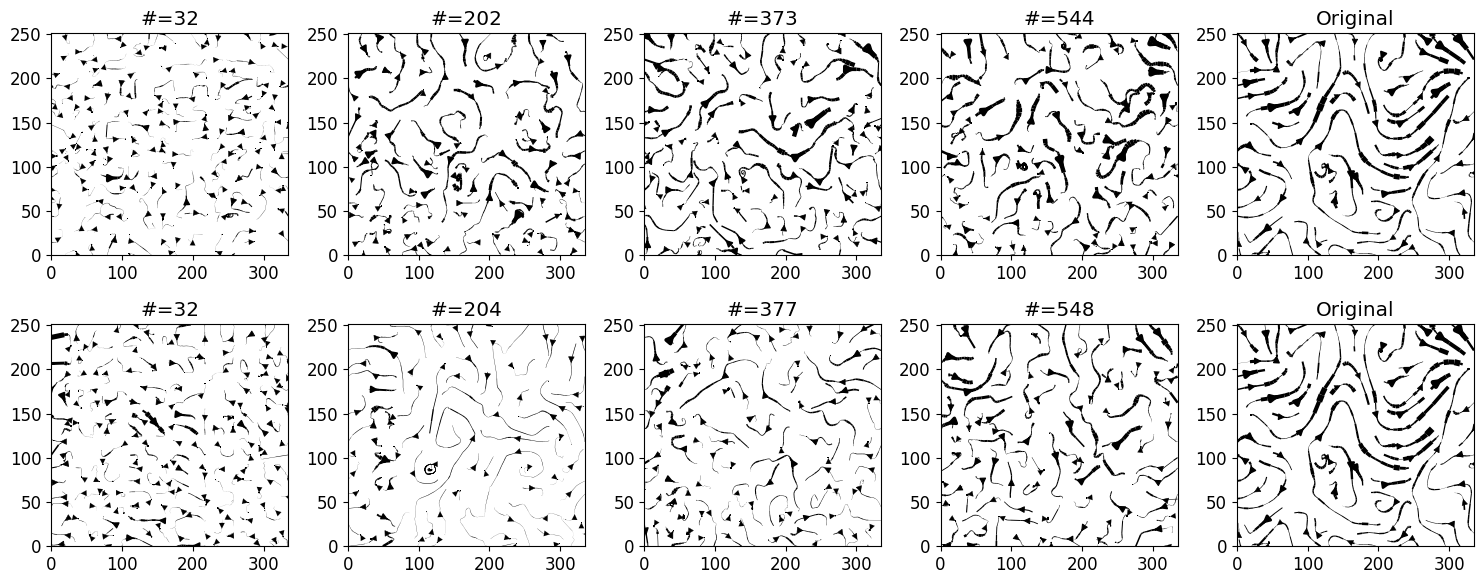

In [56]:
Y, X = np.meshgrid(np.arange(N[2]),np.arange(N[1]))

f, ax = plt.subplots(2,5,figsize=[15,6])
ax[0,0].streamplot(Y, X, PS_u1, PS_v1, density=0.6, color='k', linewidth=PS_speed1)
ax[0,1].streamplot(Y, X, PS_u2, PS_v2, density=0.6, color='k', linewidth=PS_speed2)
ax[0,2].streamplot(Y, X, PS_u3, PS_v3, density=0.6, color='k', linewidth=PS_speed3)
ax[0,3].streamplot(Y, X, PS_u4, PS_v4, density=0.6, color='k', linewidth=PS_speed4)
ax[0,4].streamplot(Y, X, A[20,:,:,0], A[20,:,:,1], density=0.6, color='k', linewidth=PS_speed4)

ax[0,0].set_title('#=' + str(nf_PS[0]))
ax[0,1].set_title('#=' + str(nf_PS[20]))
ax[0,2].set_title('#=' + str(nf_PS[40]))
ax[0,3].set_title('#=' + str(nf_PS[60]))
ax[0,4].set_title('Original')

ax[1,0].streamplot(Y, X, RS_u1, RS_v1, density=0.6, color='k', linewidth=RS_speed1)
ax[1,1].streamplot(Y, X, RS_u2, RS_v2, density=0.6, color='k', linewidth=RS_speed2)
ax[1,2].streamplot(Y, X, RS_u3, RS_v3, density=0.6, color='k', linewidth=RS_speed3)
ax[1,3].streamplot(Y, X, RS_u4, RS_v4, density=0.6, color='k', linewidth=RS_speed4)
ax[1,4].streamplot(Y, X, A[20,:,:,0], A[20,:,:,1], density=0.6, color='k', linewidth=PS_speed4)

ax[1,0].set_title('#=' + str(nf_RS[0]))
ax[1,1].set_title('#=' + str(nf_RS[20]))
ax[1,2].set_title('#=' + str(nf_RS[40]))
ax[1,3].set_title('#=' + str(nf_RS[60]))
ax[1,4].set_title('Original')

plt.tight_layout()
#plt.savefig('plots/wind_streamline.png',dpi=300)
plt.show()